In [1]:
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt
import torch.nn.init as init
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
import torch
import pandas as pd
from tqdm import tqdm
from torchsummary import summary

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [3]:
import os
os.chdir(os.getcwd().replace('/notebooks', ''))

In [4]:
df = pd.read_csv('data/preprocessed/train_preprocessed.csv')
data_array = df.values
data_tensor = torch.tensor(data_array, dtype=torch.float32)

print(data_tensor.shape)

torch.Size([1460, 77])


In [5]:
features = torch.tensor(df.iloc[:, :-2].values, dtype=torch.float32)  # Tất cả cột trừ cột cuối
labels = torch.tensor(df.iloc[:, -1].values, dtype=torch.float32).view(-1, 1)  # Cột cuối cùng

print(features.shape, labels.shape)  # Kiểm tra kích thước tensor

torch.Size([1460, 75]) torch.Size([1460, 1])


In [6]:
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size=75):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),  # Layer 1
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),          # Layer 2
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),           # Layer 3
            nn.ReLU(),
            nn.Linear(32, 1)             # Output layer
        )

    def forward(self, x):
        return self.model(x)

In [7]:
# Kích thước batch
batch_size = 32  

# Chia tập train (80%) và validation (20%)
train_size = int(0.8 * len(features))
val_size = len(features) - train_size

# Chia dataset thật thành train và validation
train_dataset, val_dataset = random_split(TensorDataset(features, labels), [train_size, val_size])

# Tạo DataLoader cho train và validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Kiểm tra một batch train
for batch_features, batch_labels in train_loader:
    print("Train Batch Shape:", batch_features.shape, batch_labels.shape)
    break  # Chỉ in thử batch đầu tiên

# Kiểm tra một batch validation
for batch_features, batch_labels in test_loader:
    print("Validation Batch Shape:", batch_features.shape, batch_labels.shape)
    break  # Chỉ in thử batch đầu tiên

Train Batch Shape: torch.Size([32, 75]) torch.Size([32, 1])
Validation Batch Shape: torch.Size([32, 75]) torch.Size([32, 1])


In [8]:
def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    num_batches = 0  # Đếm số batch
    
    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            num_batches += 1  # Cập nhật số batch

    # Trả về loss trung bình thay vì tổng loss
    return test_loss / num_batches if num_batches > 0 else float('inf')

In [9]:
# Khởi tạo mô hình và chuyển lên device
model = MLP()
summary(model, input_size = (75,))
model.to(device)
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           9,728
              ReLU-2                  [-1, 128]               0
           Dropout-3                  [-1, 128]               0
            Linear-4                   [-1, 64]           8,256
              ReLU-5                   [-1, 64]               0
           Dropout-6                   [-1, 64]               0
            Linear-7                   [-1, 32]           2,080
              ReLU-8                   [-1, 32]               0
            Linear-9                    [-1, 1]              33
Total params: 20,097
Trainable params: 20,097
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.08
Estimated Total Size (MB): 0.08
---------------------------------------------

In [10]:
# Danh sách lưu loss
train_losses = []
test_losses = []
batch_losses = []  # Lưu loss theo từng batch để minh họa chi tiết hơn

max_epoch = 200

# Training loop
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0
    batch_loss_list = []  # Lưu loss của từng batch trong epoch

    for i, (features, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{max_epoch}")):
        # Chuyển dữ liệu lên device
        features, labels = features.to(device), labels.to(device)

        optimizer.zero_grad()  # Fix lỗi thiếu dấu ()
        outputs = model(features)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        batch_loss_list.append(loss.item())  # Ghi lại loss từng batch

    # Tính trung bình loss trên tập train
    epoch_loss = running_loss / (i + 1)
    train_losses.append(epoch_loss)
    batch_losses.append(batch_loss_list)  # Ghi lại loss từng batch theo epoch

    # Đánh giá trên tập test
    model.eval()
    test_loss = evaluate(model, test_loader, criterion)
    scheduler.step(test_loss)
    test_losses.append(test_loss)

    print(f"Epoch {epoch+1}/{max_epoch} - Train Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}")

Epoch 1/200: 100%|██████████| 37/37 [00:00<00:00, 40.71it/s]


Epoch 1/200 - Train Loss: 27.6287, Test Loss: 1.0564


Epoch 2/200: 100%|██████████| 37/37 [00:00<00:00, 113.13it/s]


Epoch 2/200 - Train Loss: 7.0469, Test Loss: 1.4256


Epoch 3/200: 100%|██████████| 37/37 [00:00<00:00, 106.70it/s]


Epoch 3/200 - Train Loss: 4.9690, Test Loss: 1.5117


Epoch 4/200: 100%|██████████| 37/37 [00:00<00:00, 135.87it/s]


Epoch 4/200 - Train Loss: 4.3681, Test Loss: 1.9956


Epoch 5/200: 100%|██████████| 37/37 [00:00<00:00, 101.25it/s]


Epoch 5/200 - Train Loss: 3.6498, Test Loss: 1.8093


Epoch 6/200: 100%|██████████| 37/37 [00:00<00:00, 120.21it/s]


Epoch 6/200 - Train Loss: 3.1854, Test Loss: 1.2864


Epoch 7/200: 100%|██████████| 37/37 [00:00<00:00, 133.57it/s]


Epoch 7/200 - Train Loss: 2.5266, Test Loss: 1.1724


Epoch 8/200: 100%|██████████| 37/37 [00:00<00:00, 121.60it/s]


Epoch 8/200 - Train Loss: 2.6446, Test Loss: 1.0926


Epoch 9/200: 100%|██████████| 37/37 [00:00<00:00, 121.85it/s]


Epoch 9/200 - Train Loss: 2.3477, Test Loss: 1.0731


Epoch 10/200: 100%|██████████| 37/37 [00:00<00:00, 135.05it/s]


Epoch 10/200 - Train Loss: 2.0774, Test Loss: 1.0560


Epoch 11/200: 100%|██████████| 37/37 [00:00<00:00, 131.82it/s]


Epoch 11/200 - Train Loss: 2.1519, Test Loss: 1.0510


Epoch 12/200: 100%|██████████| 37/37 [00:00<00:00, 140.20it/s]


Epoch 12/200 - Train Loss: 2.0901, Test Loss: 1.0390


Epoch 13/200: 100%|██████████| 37/37 [00:00<00:00, 123.26it/s]


Epoch 13/200 - Train Loss: 1.9898, Test Loss: 1.0372


Epoch 14/200: 100%|██████████| 37/37 [00:00<00:00, 150.53it/s]


Epoch 14/200 - Train Loss: 1.9426, Test Loss: 1.0388


Epoch 15/200: 100%|██████████| 37/37 [00:00<00:00, 109.90it/s]


Epoch 15/200 - Train Loss: 1.8893, Test Loss: 1.0446


Epoch 16/200: 100%|██████████| 37/37 [00:00<00:00, 118.48it/s]


Epoch 16/200 - Train Loss: 1.8915, Test Loss: 1.0443


Epoch 17/200: 100%|██████████| 37/37 [00:00<00:00, 122.75it/s]


Epoch 17/200 - Train Loss: 1.7608, Test Loss: 1.0425


Epoch 18/200: 100%|██████████| 37/37 [00:00<00:00, 122.14it/s]


Epoch 18/200 - Train Loss: 1.7005, Test Loss: 1.0641


Epoch 19/200: 100%|██████████| 37/37 [00:00<00:00, 118.42it/s]


Epoch 19/200 - Train Loss: 1.6638, Test Loss: 1.0556


Epoch 20/200: 100%|██████████| 37/37 [00:00<00:00, 120.04it/s]


Epoch 20/200 - Train Loss: 1.6084, Test Loss: 1.0511


Epoch 21/200: 100%|██████████| 37/37 [00:00<00:00, 118.20it/s]


Epoch 21/200 - Train Loss: 1.6622, Test Loss: 1.0566


Epoch 22/200: 100%|██████████| 37/37 [00:00<00:00, 120.32it/s]


Epoch 22/200 - Train Loss: 1.6106, Test Loss: 1.0650


Epoch 23/200: 100%|██████████| 37/37 [00:00<00:00, 126.96it/s]


Epoch 23/200 - Train Loss: 1.7991, Test Loss: 1.0622


Epoch 24/200: 100%|██████████| 37/37 [00:00<00:00, 116.32it/s]


Epoch 24/200 - Train Loss: 1.6267, Test Loss: 1.0608


Epoch 25/200: 100%|██████████| 37/37 [00:00<00:00, 104.24it/s]


Epoch 25/200 - Train Loss: 1.5720, Test Loss: 1.0688


Epoch 26/200: 100%|██████████| 37/37 [00:00<00:00, 116.68it/s]


Epoch 26/200 - Train Loss: 1.6486, Test Loss: 1.0707


Epoch 27/200: 100%|██████████| 37/37 [00:00<00:00, 122.04it/s]


Epoch 27/200 - Train Loss: 1.7473, Test Loss: 1.0667


Epoch 28/200: 100%|██████████| 37/37 [00:00<00:00, 120.23it/s]


Epoch 28/200 - Train Loss: 1.6269, Test Loss: 1.0671


Epoch 29/200: 100%|██████████| 37/37 [00:00<00:00, 122.98it/s]


Epoch 29/200 - Train Loss: 1.5444, Test Loss: 1.0631


Epoch 30/200: 100%|██████████| 37/37 [00:00<00:00, 121.98it/s]


Epoch 30/200 - Train Loss: 1.3944, Test Loss: 1.0707


Epoch 31/200: 100%|██████████| 37/37 [00:00<00:00, 123.02it/s]


Epoch 31/200 - Train Loss: 1.5503, Test Loss: 1.0686


Epoch 32/200: 100%|██████████| 37/37 [00:00<00:00, 120.48it/s]


Epoch 32/200 - Train Loss: 1.5697, Test Loss: 1.0670


Epoch 33/200: 100%|██████████| 37/37 [00:00<00:00, 123.21it/s]


Epoch 33/200 - Train Loss: 1.6248, Test Loss: 1.0662


Epoch 34/200: 100%|██████████| 37/37 [00:00<00:00, 122.20it/s]


Epoch 34/200 - Train Loss: 1.5212, Test Loss: 1.0632


Epoch 35/200: 100%|██████████| 37/37 [00:00<00:00, 129.72it/s]


Epoch 35/200 - Train Loss: 1.5019, Test Loss: 1.0643


Epoch 36/200: 100%|██████████| 37/37 [00:00<00:00, 120.26it/s]


Epoch 36/200 - Train Loss: 1.4510, Test Loss: 1.0654


Epoch 37/200: 100%|██████████| 37/37 [00:00<00:00, 120.01it/s]


Epoch 37/200 - Train Loss: 1.4992, Test Loss: 1.0630


Epoch 38/200: 100%|██████████| 37/37 [00:00<00:00, 118.00it/s]


Epoch 38/200 - Train Loss: 1.5355, Test Loss: 1.0624


Epoch 39/200: 100%|██████████| 37/37 [00:00<00:00, 122.93it/s]


Epoch 39/200 - Train Loss: 1.5282, Test Loss: 1.0604


Epoch 40/200: 100%|██████████| 37/37 [00:00<00:00, 120.47it/s]


Epoch 40/200 - Train Loss: 1.5908, Test Loss: 1.0602


Epoch 41/200: 100%|██████████| 37/37 [00:00<00:00, 110.76it/s]


Epoch 41/200 - Train Loss: 1.6075, Test Loss: 1.0590


Epoch 42/200: 100%|██████████| 37/37 [00:00<00:00, 121.26it/s]


Epoch 42/200 - Train Loss: 1.4690, Test Loss: 1.0582


Epoch 43/200: 100%|██████████| 37/37 [00:00<00:00, 122.59it/s]


Epoch 43/200 - Train Loss: 1.5766, Test Loss: 1.0591


Epoch 44/200: 100%|██████████| 37/37 [00:00<00:00, 125.26it/s]


Epoch 44/200 - Train Loss: 1.6116, Test Loss: 1.0599


Epoch 45/200: 100%|██████████| 37/37 [00:00<00:00, 121.10it/s]


Epoch 45/200 - Train Loss: 1.4958, Test Loss: 1.0598


Epoch 46/200: 100%|██████████| 37/37 [00:00<00:00, 124.70it/s]


Epoch 46/200 - Train Loss: 1.6373, Test Loss: 1.0602


Epoch 47/200: 100%|██████████| 37/37 [00:00<00:00, 123.05it/s]


Epoch 47/200 - Train Loss: 1.5934, Test Loss: 1.0606


Epoch 48/200: 100%|██████████| 37/37 [00:00<00:00, 121.89it/s]


Epoch 48/200 - Train Loss: 1.5538, Test Loss: 1.0608


Epoch 49/200: 100%|██████████| 37/37 [00:00<00:00, 118.14it/s]


Epoch 49/200 - Train Loss: 1.5252, Test Loss: 1.0611


Epoch 50/200: 100%|██████████| 37/37 [00:00<00:00, 119.33it/s]


Epoch 50/200 - Train Loss: 1.5087, Test Loss: 1.0610


Epoch 51/200: 100%|██████████| 37/37 [00:00<00:00, 118.23it/s]


Epoch 51/200 - Train Loss: 1.6080, Test Loss: 1.0612


Epoch 52/200: 100%|██████████| 37/37 [00:00<00:00, 120.14it/s]


Epoch 52/200 - Train Loss: 1.4966, Test Loss: 1.0615


Epoch 53/200: 100%|██████████| 37/37 [00:00<00:00, 122.67it/s]


Epoch 53/200 - Train Loss: 1.4929, Test Loss: 1.0616


Epoch 54/200: 100%|██████████| 37/37 [00:00<00:00, 122.07it/s]


Epoch 54/200 - Train Loss: 1.5508, Test Loss: 1.0615


Epoch 55/200: 100%|██████████| 37/37 [00:00<00:00, 121.14it/s]


Epoch 55/200 - Train Loss: 1.5291, Test Loss: 1.0615


Epoch 56/200: 100%|██████████| 37/37 [00:00<00:00, 125.87it/s]


Epoch 56/200 - Train Loss: 1.5041, Test Loss: 1.0613


Epoch 57/200: 100%|██████████| 37/37 [00:00<00:00, 106.94it/s]


Epoch 57/200 - Train Loss: 1.5800, Test Loss: 1.0615


Epoch 58/200: 100%|██████████| 37/37 [00:00<00:00, 112.17it/s]


Epoch 58/200 - Train Loss: 1.5502, Test Loss: 1.0615


Epoch 59/200: 100%|██████████| 37/37 [00:00<00:00, 128.92it/s]


Epoch 59/200 - Train Loss: 1.5136, Test Loss: 1.0616


Epoch 60/200: 100%|██████████| 37/37 [00:00<00:00, 118.96it/s]


Epoch 60/200 - Train Loss: 1.5155, Test Loss: 1.0615


Epoch 61/200: 100%|██████████| 37/37 [00:00<00:00, 115.45it/s]


Epoch 61/200 - Train Loss: 1.5137, Test Loss: 1.0614


Epoch 62/200: 100%|██████████| 37/37 [00:00<00:00, 116.87it/s]


Epoch 62/200 - Train Loss: 1.5240, Test Loss: 1.0613


Epoch 63/200: 100%|██████████| 37/37 [00:00<00:00, 105.28it/s]


Epoch 63/200 - Train Loss: 1.4727, Test Loss: 1.0613


Epoch 64/200: 100%|██████████| 37/37 [00:00<00:00, 116.28it/s]


Epoch 64/200 - Train Loss: 1.5553, Test Loss: 1.0614


Epoch 65/200: 100%|██████████| 37/37 [00:00<00:00, 115.81it/s]


Epoch 65/200 - Train Loss: 1.4318, Test Loss: 1.0614


Epoch 66/200: 100%|██████████| 37/37 [00:00<00:00, 105.26it/s]


Epoch 66/200 - Train Loss: 1.3767, Test Loss: 1.0614


Epoch 67/200: 100%|██████████| 37/37 [00:00<00:00, 122.98it/s]


Epoch 67/200 - Train Loss: 1.6092, Test Loss: 1.0615


Epoch 68/200: 100%|██████████| 37/37 [00:00<00:00, 119.17it/s]


Epoch 68/200 - Train Loss: 1.5337, Test Loss: 1.0616


Epoch 69/200: 100%|██████████| 37/37 [00:00<00:00, 117.97it/s]


Epoch 69/200 - Train Loss: 1.4839, Test Loss: 1.0617


Epoch 70/200: 100%|██████████| 37/37 [00:00<00:00, 124.15it/s]


Epoch 70/200 - Train Loss: 1.6060, Test Loss: 1.0617


Epoch 71/200: 100%|██████████| 37/37 [00:00<00:00, 110.74it/s]


Epoch 71/200 - Train Loss: 1.5250, Test Loss: 1.0617


Epoch 72/200: 100%|██████████| 37/37 [00:00<00:00, 100.79it/s]


Epoch 72/200 - Train Loss: 1.5556, Test Loss: 1.0618


Epoch 73/200: 100%|██████████| 37/37 [00:00<00:00, 106.91it/s]


Epoch 73/200 - Train Loss: 1.4999, Test Loss: 1.0618


Epoch 74/200: 100%|██████████| 37/37 [00:00<00:00, 112.39it/s]


Epoch 74/200 - Train Loss: 1.5595, Test Loss: 1.0618


Epoch 75/200: 100%|██████████| 37/37 [00:00<00:00, 117.73it/s]


Epoch 75/200 - Train Loss: 1.4995, Test Loss: 1.0618


Epoch 76/200: 100%|██████████| 37/37 [00:00<00:00, 117.70it/s]


Epoch 76/200 - Train Loss: 1.4838, Test Loss: 1.0618


Epoch 77/200: 100%|██████████| 37/37 [00:00<00:00, 125.51it/s]


Epoch 77/200 - Train Loss: 1.5463, Test Loss: 1.0618


Epoch 78/200: 100%|██████████| 37/37 [00:00<00:00, 120.78it/s]


Epoch 78/200 - Train Loss: 1.5036, Test Loss: 1.0618


Epoch 79/200: 100%|██████████| 37/37 [00:00<00:00, 112.78it/s]


Epoch 79/200 - Train Loss: 1.4312, Test Loss: 1.0618


Epoch 80/200: 100%|██████████| 37/37 [00:00<00:00, 105.18it/s]


Epoch 80/200 - Train Loss: 1.6227, Test Loss: 1.0618


Epoch 81/200: 100%|██████████| 37/37 [00:00<00:00, 108.12it/s]


Epoch 81/200 - Train Loss: 1.4629, Test Loss: 1.0618


Epoch 82/200: 100%|██████████| 37/37 [00:00<00:00, 116.83it/s]


Epoch 82/200 - Train Loss: 1.5360, Test Loss: 1.0619


Epoch 83/200: 100%|██████████| 37/37 [00:00<00:00, 118.76it/s]


Epoch 83/200 - Train Loss: 1.4878, Test Loss: 1.0619


Epoch 84/200: 100%|██████████| 37/37 [00:00<00:00, 98.97it/s] 


Epoch 84/200 - Train Loss: 1.5525, Test Loss: 1.0619


Epoch 85/200: 100%|██████████| 37/37 [00:00<00:00, 123.18it/s]


Epoch 85/200 - Train Loss: 1.4861, Test Loss: 1.0619


Epoch 86/200: 100%|██████████| 37/37 [00:00<00:00, 121.54it/s]


Epoch 86/200 - Train Loss: 1.5815, Test Loss: 1.0619


Epoch 87/200: 100%|██████████| 37/37 [00:00<00:00, 142.43it/s]


Epoch 87/200 - Train Loss: 1.5316, Test Loss: 1.0619


Epoch 88/200: 100%|██████████| 37/37 [00:00<00:00, 127.79it/s]


Epoch 88/200 - Train Loss: 1.5422, Test Loss: 1.0619


Epoch 89/200: 100%|██████████| 37/37 [00:00<00:00, 104.24it/s]


Epoch 89/200 - Train Loss: 1.5061, Test Loss: 1.0619


Epoch 90/200: 100%|██████████| 37/37 [00:00<00:00, 128.92it/s]


Epoch 90/200 - Train Loss: 1.5226, Test Loss: 1.0619


Epoch 91/200: 100%|██████████| 37/37 [00:00<00:00, 137.28it/s]


Epoch 91/200 - Train Loss: 1.5608, Test Loss: 1.0619


Epoch 92/200: 100%|██████████| 37/37 [00:00<00:00, 140.05it/s]


Epoch 92/200 - Train Loss: 1.5674, Test Loss: 1.0619


Epoch 93/200: 100%|██████████| 37/37 [00:00<00:00, 120.65it/s]


Epoch 93/200 - Train Loss: 1.4985, Test Loss: 1.0619


Epoch 94/200: 100%|██████████| 37/37 [00:00<00:00, 137.71it/s]


Epoch 94/200 - Train Loss: 1.4153, Test Loss: 1.0619


Epoch 95/200: 100%|██████████| 37/37 [00:00<00:00, 123.23it/s]


Epoch 95/200 - Train Loss: 1.4703, Test Loss: 1.0619


Epoch 96/200: 100%|██████████| 37/37 [00:00<00:00, 122.67it/s]


Epoch 96/200 - Train Loss: 1.5681, Test Loss: 1.0619


Epoch 97/200: 100%|██████████| 37/37 [00:00<00:00, 123.74it/s]


Epoch 97/200 - Train Loss: 1.5276, Test Loss: 1.0619


Epoch 98/200: 100%|██████████| 37/37 [00:00<00:00, 122.62it/s]


Epoch 98/200 - Train Loss: 1.5070, Test Loss: 1.0619


Epoch 99/200: 100%|██████████| 37/37 [00:00<00:00, 123.09it/s]


Epoch 99/200 - Train Loss: 1.4320, Test Loss: 1.0619


Epoch 100/200: 100%|██████████| 37/37 [00:00<00:00, 136.64it/s]


Epoch 100/200 - Train Loss: 1.4911, Test Loss: 1.0619


Epoch 101/200: 100%|██████████| 37/37 [00:00<00:00, 123.47it/s]


Epoch 101/200 - Train Loss: 1.5821, Test Loss: 1.0619


Epoch 102/200: 100%|██████████| 37/37 [00:00<00:00, 122.76it/s]


Epoch 102/200 - Train Loss: 1.4844, Test Loss: 1.0619


Epoch 103/200: 100%|██████████| 37/37 [00:00<00:00, 124.08it/s]


Epoch 103/200 - Train Loss: 1.5613, Test Loss: 1.0619


Epoch 104/200: 100%|██████████| 37/37 [00:00<00:00, 109.92it/s]


Epoch 104/200 - Train Loss: 1.4945, Test Loss: 1.0619


Epoch 105/200: 100%|██████████| 37/37 [00:00<00:00, 118.24it/s]


Epoch 105/200 - Train Loss: 1.6601, Test Loss: 1.0619


Epoch 106/200: 100%|██████████| 37/37 [00:00<00:00, 125.99it/s]


Epoch 106/200 - Train Loss: 1.5140, Test Loss: 1.0619


Epoch 107/200: 100%|██████████| 37/37 [00:00<00:00, 120.89it/s]


Epoch 107/200 - Train Loss: 1.4072, Test Loss: 1.0619


Epoch 108/200: 100%|██████████| 37/37 [00:00<00:00, 119.53it/s]


Epoch 108/200 - Train Loss: 1.6017, Test Loss: 1.0619


Epoch 109/200: 100%|██████████| 37/37 [00:00<00:00, 118.89it/s]


Epoch 109/200 - Train Loss: 1.4995, Test Loss: 1.0619


Epoch 110/200: 100%|██████████| 37/37 [00:00<00:00, 124.66it/s]


Epoch 110/200 - Train Loss: 1.6653, Test Loss: 1.0619


Epoch 111/200: 100%|██████████| 37/37 [00:00<00:00, 113.81it/s]


Epoch 111/200 - Train Loss: 1.4524, Test Loss: 1.0619


Epoch 112/200: 100%|██████████| 37/37 [00:00<00:00, 116.99it/s]


Epoch 112/200 - Train Loss: 1.5148, Test Loss: 1.0619


Epoch 113/200: 100%|██████████| 37/37 [00:00<00:00, 126.54it/s]


Epoch 113/200 - Train Loss: 1.5762, Test Loss: 1.0619


Epoch 114/200: 100%|██████████| 37/37 [00:00<00:00, 114.19it/s]


Epoch 114/200 - Train Loss: 1.6098, Test Loss: 1.0619


Epoch 115/200: 100%|██████████| 37/37 [00:00<00:00, 124.99it/s]


Epoch 115/200 - Train Loss: 1.4760, Test Loss: 1.0619


Epoch 116/200: 100%|██████████| 37/37 [00:00<00:00, 124.69it/s]


Epoch 116/200 - Train Loss: 1.5256, Test Loss: 1.0619


Epoch 117/200: 100%|██████████| 37/37 [00:00<00:00, 147.38it/s]


Epoch 117/200 - Train Loss: 1.5003, Test Loss: 1.0619


Epoch 118/200: 100%|██████████| 37/37 [00:00<00:00, 128.41it/s]


Epoch 118/200 - Train Loss: 1.5699, Test Loss: 1.0619


Epoch 119/200: 100%|██████████| 37/37 [00:00<00:00, 135.62it/s]


Epoch 119/200 - Train Loss: 1.5530, Test Loss: 1.0619


Epoch 120/200: 100%|██████████| 37/37 [00:00<00:00, 126.57it/s]


Epoch 120/200 - Train Loss: 1.5612, Test Loss: 1.0619


Epoch 121/200: 100%|██████████| 37/37 [00:00<00:00, 122.91it/s]


Epoch 121/200 - Train Loss: 1.5497, Test Loss: 1.0619


Epoch 122/200: 100%|██████████| 37/37 [00:00<00:00, 124.76it/s]


Epoch 122/200 - Train Loss: 1.5846, Test Loss: 1.0619


Epoch 123/200: 100%|██████████| 37/37 [00:00<00:00, 120.46it/s]


Epoch 123/200 - Train Loss: 1.4156, Test Loss: 1.0619


Epoch 124/200: 100%|██████████| 37/37 [00:00<00:00, 123.41it/s]


Epoch 124/200 - Train Loss: 1.6133, Test Loss: 1.0619


Epoch 125/200: 100%|██████████| 37/37 [00:00<00:00, 143.68it/s]


Epoch 125/200 - Train Loss: 1.4864, Test Loss: 1.0619


Epoch 126/200: 100%|██████████| 37/37 [00:00<00:00, 122.55it/s]


Epoch 126/200 - Train Loss: 1.4595, Test Loss: 1.0619


Epoch 127/200: 100%|██████████| 37/37 [00:00<00:00, 123.69it/s]


Epoch 127/200 - Train Loss: 1.5719, Test Loss: 1.0619


Epoch 128/200: 100%|██████████| 37/37 [00:00<00:00, 125.43it/s]


Epoch 128/200 - Train Loss: 1.5730, Test Loss: 1.0619


Epoch 129/200: 100%|██████████| 37/37 [00:00<00:00, 117.71it/s]


Epoch 129/200 - Train Loss: 1.5113, Test Loss: 1.0619


Epoch 130/200: 100%|██████████| 37/37 [00:00<00:00, 123.72it/s]


Epoch 130/200 - Train Loss: 1.5837, Test Loss: 1.0619


Epoch 131/200: 100%|██████████| 37/37 [00:00<00:00, 122.12it/s]


Epoch 131/200 - Train Loss: 1.5372, Test Loss: 1.0619


Epoch 132/200: 100%|██████████| 37/37 [00:00<00:00, 127.57it/s]


Epoch 132/200 - Train Loss: 1.5558, Test Loss: 1.0619


Epoch 133/200: 100%|██████████| 37/37 [00:00<00:00, 118.16it/s]


Epoch 133/200 - Train Loss: 1.5849, Test Loss: 1.0619


Epoch 134/200: 100%|██████████| 37/37 [00:00<00:00, 105.89it/s]


Epoch 134/200 - Train Loss: 1.4749, Test Loss: 1.0619


Epoch 135/200: 100%|██████████| 37/37 [00:00<00:00, 107.72it/s]


Epoch 135/200 - Train Loss: 1.4480, Test Loss: 1.0620


Epoch 136/200: 100%|██████████| 37/37 [00:00<00:00, 123.54it/s]


Epoch 136/200 - Train Loss: 1.5364, Test Loss: 1.0620


Epoch 137/200: 100%|██████████| 37/37 [00:00<00:00, 128.45it/s]


Epoch 137/200 - Train Loss: 1.5281, Test Loss: 1.0620


Epoch 138/200: 100%|██████████| 37/37 [00:00<00:00, 118.29it/s]


Epoch 138/200 - Train Loss: 1.3766, Test Loss: 1.0620


Epoch 139/200: 100%|██████████| 37/37 [00:00<00:00, 122.27it/s]


Epoch 139/200 - Train Loss: 1.5484, Test Loss: 1.0620


Epoch 140/200: 100%|██████████| 37/37 [00:00<00:00, 119.69it/s]


Epoch 140/200 - Train Loss: 1.5188, Test Loss: 1.0620


Epoch 141/200: 100%|██████████| 37/37 [00:00<00:00, 122.48it/s]


Epoch 141/200 - Train Loss: 1.5142, Test Loss: 1.0620


Epoch 142/200: 100%|██████████| 37/37 [00:00<00:00, 125.90it/s]


Epoch 142/200 - Train Loss: 1.5116, Test Loss: 1.0620


Epoch 143/200: 100%|██████████| 37/37 [00:00<00:00, 112.89it/s]


Epoch 143/200 - Train Loss: 1.5522, Test Loss: 1.0620


Epoch 144/200: 100%|██████████| 37/37 [00:00<00:00, 127.38it/s]


Epoch 144/200 - Train Loss: 1.4260, Test Loss: 1.0620


Epoch 145/200: 100%|██████████| 37/37 [00:00<00:00, 127.63it/s]


Epoch 145/200 - Train Loss: 1.5657, Test Loss: 1.0620


Epoch 146/200: 100%|██████████| 37/37 [00:00<00:00, 118.58it/s]


Epoch 146/200 - Train Loss: 1.4622, Test Loss: 1.0620


Epoch 147/200: 100%|██████████| 37/37 [00:00<00:00, 131.07it/s]


Epoch 147/200 - Train Loss: 1.5561, Test Loss: 1.0620


Epoch 148/200: 100%|██████████| 37/37 [00:00<00:00, 122.00it/s]


Epoch 148/200 - Train Loss: 1.5052, Test Loss: 1.0620


Epoch 149/200: 100%|██████████| 37/37 [00:00<00:00, 124.77it/s]


Epoch 149/200 - Train Loss: 1.4350, Test Loss: 1.0620


Epoch 150/200: 100%|██████████| 37/37 [00:00<00:00, 138.51it/s]


Epoch 150/200 - Train Loss: 1.4231, Test Loss: 1.0620


Epoch 151/200: 100%|██████████| 37/37 [00:00<00:00, 120.86it/s]


Epoch 151/200 - Train Loss: 1.4565, Test Loss: 1.0620


Epoch 152/200: 100%|██████████| 37/37 [00:00<00:00, 130.33it/s]


Epoch 152/200 - Train Loss: 1.5002, Test Loss: 1.0620


Epoch 153/200: 100%|██████████| 37/37 [00:00<00:00, 129.35it/s]


Epoch 153/200 - Train Loss: 1.5690, Test Loss: 1.0620


Epoch 154/200: 100%|██████████| 37/37 [00:00<00:00, 127.22it/s]


Epoch 154/200 - Train Loss: 1.4339, Test Loss: 1.0620


Epoch 155/200: 100%|██████████| 37/37 [00:00<00:00, 122.45it/s]


Epoch 155/200 - Train Loss: 1.4370, Test Loss: 1.0620


Epoch 156/200: 100%|██████████| 37/37 [00:00<00:00, 126.94it/s]


Epoch 156/200 - Train Loss: 1.5051, Test Loss: 1.0620


Epoch 157/200: 100%|██████████| 37/37 [00:00<00:00, 122.87it/s]


Epoch 157/200 - Train Loss: 1.5163, Test Loss: 1.0620


Epoch 158/200: 100%|██████████| 37/37 [00:00<00:00, 124.52it/s]


Epoch 158/200 - Train Loss: 1.5598, Test Loss: 1.0620


Epoch 159/200: 100%|██████████| 37/37 [00:00<00:00, 122.70it/s]


Epoch 159/200 - Train Loss: 1.4882, Test Loss: 1.0620


Epoch 160/200: 100%|██████████| 37/37 [00:00<00:00, 116.39it/s]


Epoch 160/200 - Train Loss: 1.4979, Test Loss: 1.0620


Epoch 161/200: 100%|██████████| 37/37 [00:00<00:00, 123.56it/s]


Epoch 161/200 - Train Loss: 1.4573, Test Loss: 1.0620


Epoch 162/200: 100%|██████████| 37/37 [00:00<00:00, 111.67it/s]


Epoch 162/200 - Train Loss: 1.5265, Test Loss: 1.0620


Epoch 163/200: 100%|██████████| 37/37 [00:00<00:00, 115.97it/s]


Epoch 163/200 - Train Loss: 1.4201, Test Loss: 1.0620


Epoch 164/200: 100%|██████████| 37/37 [00:00<00:00, 120.46it/s]


Epoch 164/200 - Train Loss: 1.4277, Test Loss: 1.0620


Epoch 165/200: 100%|██████████| 37/37 [00:00<00:00, 122.83it/s]


Epoch 165/200 - Train Loss: 1.4606, Test Loss: 1.0620


Epoch 166/200: 100%|██████████| 37/37 [00:00<00:00, 121.50it/s]


Epoch 166/200 - Train Loss: 1.4845, Test Loss: 1.0620


Epoch 167/200: 100%|██████████| 37/37 [00:00<00:00, 119.27it/s]


Epoch 167/200 - Train Loss: 1.4458, Test Loss: 1.0620


Epoch 168/200: 100%|██████████| 37/37 [00:00<00:00, 123.68it/s]


Epoch 168/200 - Train Loss: 1.4720, Test Loss: 1.0620


Epoch 169/200: 100%|██████████| 37/37 [00:00<00:00, 121.21it/s]


Epoch 169/200 - Train Loss: 1.4832, Test Loss: 1.0620


Epoch 170/200: 100%|██████████| 37/37 [00:00<00:00, 125.02it/s]


Epoch 170/200 - Train Loss: 1.5002, Test Loss: 1.0620


Epoch 171/200: 100%|██████████| 37/37 [00:00<00:00, 123.24it/s]


Epoch 171/200 - Train Loss: 1.5303, Test Loss: 1.0620


Epoch 172/200: 100%|██████████| 37/37 [00:00<00:00, 117.93it/s]


Epoch 172/200 - Train Loss: 1.6132, Test Loss: 1.0620


Epoch 173/200: 100%|██████████| 37/37 [00:00<00:00, 121.25it/s]


Epoch 173/200 - Train Loss: 1.4341, Test Loss: 1.0621


Epoch 174/200: 100%|██████████| 37/37 [00:00<00:00, 129.28it/s]


Epoch 174/200 - Train Loss: 1.5133, Test Loss: 1.0621


Epoch 175/200: 100%|██████████| 37/37 [00:00<00:00, 132.54it/s]


Epoch 175/200 - Train Loss: 1.5098, Test Loss: 1.0621


Epoch 176/200: 100%|██████████| 37/37 [00:00<00:00, 119.60it/s]


Epoch 176/200 - Train Loss: 1.6145, Test Loss: 1.0621


Epoch 177/200: 100%|██████████| 37/37 [00:00<00:00, 125.41it/s]


Epoch 177/200 - Train Loss: 1.4257, Test Loss: 1.0621


Epoch 178/200: 100%|██████████| 37/37 [00:00<00:00, 127.07it/s]


Epoch 178/200 - Train Loss: 1.6129, Test Loss: 1.0621


Epoch 179/200: 100%|██████████| 37/37 [00:00<00:00, 105.52it/s]


Epoch 179/200 - Train Loss: 1.4219, Test Loss: 1.0621


Epoch 180/200: 100%|██████████| 37/37 [00:00<00:00, 123.64it/s]


Epoch 180/200 - Train Loss: 1.5449, Test Loss: 1.0621


Epoch 181/200: 100%|██████████| 37/37 [00:00<00:00, 136.44it/s]


Epoch 181/200 - Train Loss: 1.5072, Test Loss: 1.0621


Epoch 182/200: 100%|██████████| 37/37 [00:00<00:00, 126.14it/s]


Epoch 182/200 - Train Loss: 1.4723, Test Loss: 1.0621


Epoch 183/200: 100%|██████████| 37/37 [00:00<00:00, 121.48it/s]


Epoch 183/200 - Train Loss: 1.5805, Test Loss: 1.0621


Epoch 184/200: 100%|██████████| 37/37 [00:00<00:00, 95.26it/s]


Epoch 184/200 - Train Loss: 1.5740, Test Loss: 1.0621


Epoch 185/200: 100%|██████████| 37/37 [00:00<00:00, 78.21it/s]


Epoch 185/200 - Train Loss: 1.5295, Test Loss: 1.0621


Epoch 186/200: 100%|██████████| 37/37 [00:00<00:00, 79.69it/s] 


Epoch 186/200 - Train Loss: 1.6049, Test Loss: 1.0621


Epoch 187/200: 100%|██████████| 37/37 [00:00<00:00, 102.86it/s]


Epoch 187/200 - Train Loss: 1.5212, Test Loss: 1.0621


Epoch 188/200: 100%|██████████| 37/37 [00:00<00:00, 102.89it/s]


Epoch 188/200 - Train Loss: 1.5273, Test Loss: 1.0621


Epoch 189/200: 100%|██████████| 37/37 [00:00<00:00, 92.60it/s]


Epoch 189/200 - Train Loss: 1.3562, Test Loss: 1.0621


Epoch 190/200: 100%|██████████| 37/37 [00:00<00:00, 103.81it/s]


Epoch 190/200 - Train Loss: 1.5186, Test Loss: 1.0621


Epoch 191/200: 100%|██████████| 37/37 [00:00<00:00, 113.08it/s]


Epoch 191/200 - Train Loss: 1.5940, Test Loss: 1.0621


Epoch 192/200: 100%|██████████| 37/37 [00:00<00:00, 101.80it/s]


Epoch 192/200 - Train Loss: 1.4485, Test Loss: 1.0621


Epoch 193/200: 100%|██████████| 37/37 [00:00<00:00, 120.57it/s]


Epoch 193/200 - Train Loss: 1.5086, Test Loss: 1.0621


Epoch 194/200: 100%|██████████| 37/37 [00:00<00:00, 106.21it/s]


Epoch 194/200 - Train Loss: 1.5512, Test Loss: 1.0621


Epoch 195/200: 100%|██████████| 37/37 [00:00<00:00, 121.01it/s]


Epoch 195/200 - Train Loss: 1.5662, Test Loss: 1.0621


Epoch 196/200: 100%|██████████| 37/37 [00:00<00:00, 132.75it/s]


Epoch 196/200 - Train Loss: 1.5808, Test Loss: 1.0621


Epoch 197/200: 100%|██████████| 37/37 [00:00<00:00, 141.79it/s]


Epoch 197/200 - Train Loss: 1.4938, Test Loss: 1.0621


Epoch 198/200: 100%|██████████| 37/37 [00:00<00:00, 137.31it/s]


Epoch 198/200 - Train Loss: 1.5696, Test Loss: 1.0621


Epoch 199/200: 100%|██████████| 37/37 [00:00<00:00, 126.44it/s]


Epoch 199/200 - Train Loss: 1.5984, Test Loss: 1.0621


Epoch 200/200: 100%|██████████| 37/37 [00:00<00:00, 112.11it/s]

Epoch 200/200 - Train Loss: 1.4351, Test Loss: 1.0622


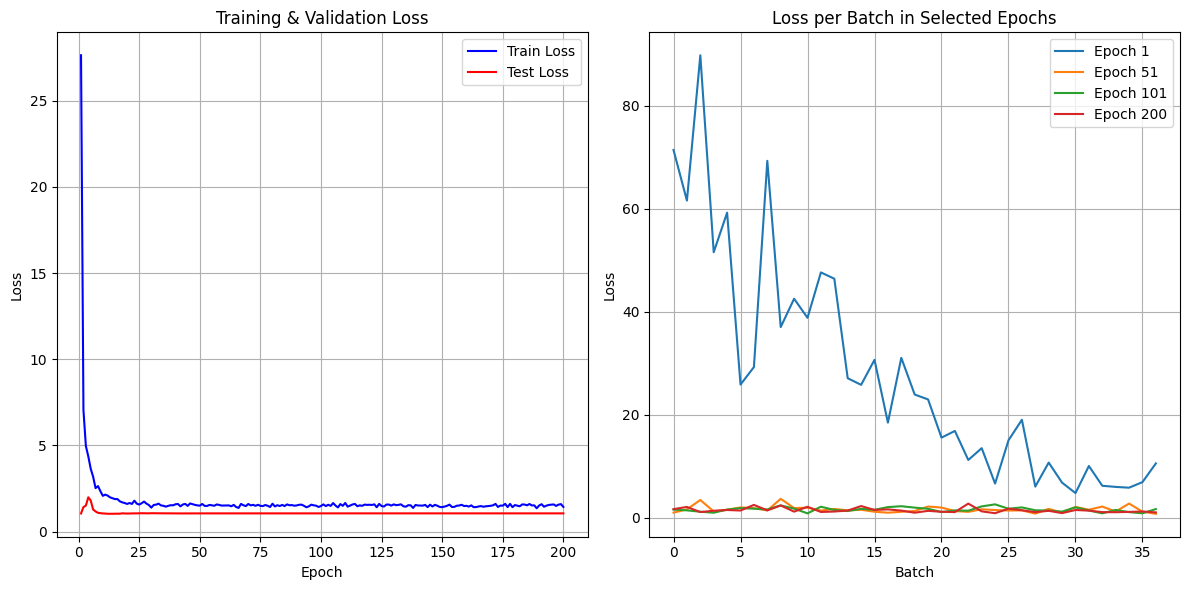

In [11]:
# Vẽ loss theo epoch
plt.figure(figsize=(12, 6))

# Vẽ Train & Validation Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, max_epoch+1), train_losses, label="Train Loss", color="blue")
plt.plot(range(1, max_epoch+1), test_losses, label="Test Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
for epoch in [0, max_epoch//4, max_epoch//2, max_epoch-1]:  # Chọn vài epoch để hiển thị
    plt.plot(batch_losses[epoch], label=f"Epoch {epoch+1}")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Loss per Batch in Selected Epochs")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [12]:
torch.save(model, './model/model.pth')

In [13]:
filepath = os.path.join('data', 'raw', 'test.csv')
data = pd.read_csv(filepath, index_col='Id')

# Loại bỏ cột cuối cùng khỏi danh sách cột xử lý
columns_to_process = data.columns

# Find columns with missing values
lst_of_missing = [col for col in columns_to_process if data[col].isnull().sum() > 0]

# Find numerical and categorical columns
lst_of_numerical = [col for col in columns_to_process if data[col].dtype != 'object']
lst_of_categorical = [col for col in columns_to_process if data[col].dtype == 'object']

# Print information about missing categorical columns
cat_missing = set(lst_of_categorical) & set(lst_of_missing)
print(f'There are {len(cat_missing)} categorical columns with missing values')
for col in cat_missing:
    print(f'{col:<13}: {data[col].isnull().sum(): <4} missing values - {data[col].isnull().sum() / len(data) * 100:.2f}% - {len(data[col].unique())} unique values')

# Save preprocessed data
output_dir = os.path.join('data', 'preprocessed')
os.makedirs(output_dir, exist_ok=True)
output_filepath = os.path.join(output_dir, 'test_preprocessed.csv')
data.to_csv(output_filepath)
print(f"Preprocessed data saved to {output_filepath}")

There are 22 categorical columns with missing values
MSZoning     : 4    missing values - 0.27% - 6 unique values
Alley        : 1352 missing values - 92.67% - 3 unique values
GarageFinish : 78   missing values - 5.35% - 4 unique values
PoolQC       : 1456 missing values - 99.79% - 3 unique values
Utilities    : 2    missing values - 0.14% - 2 unique values
GarageCond   : 78   missing values - 5.35% - 6 unique values
BsmtQual     : 44   missing values - 3.02% - 5 unique values
Exterior2nd  : 1    missing values - 0.07% - 16 unique values
KitchenQual  : 1    missing values - 0.07% - 5 unique values
GarageQual   : 78   missing values - 5.35% - 5 unique values
BsmtFinType1 : 42   missing values - 2.88% - 7 unique values
Functional   : 2    missing values - 0.14% - 8 unique values
FireplaceQu  : 730  missing values - 50.03% - 6 unique values
Exterior1st  : 1    missing values - 0.07% - 14 unique values
BsmtExposure : 44   missing values - 3.02% - 5 unique values
BsmtCond     : 45   missing

In [14]:
filepath = './data/preprocessed/test_preprocessed.csv'
data = pd.read_csv(filepath, index_col='Id')

# Fill missing values
data['LotFrontage'] = data['LotFrontage'].fillna(data[data['LotFrontage'] < 300]['LotFrontage'].mean())
data['GarageYrBlt'] = data['GarageYrBlt'].fillna(data['GarageYrBlt'].interpolate())
data['MasVnrArea'] = data['MasVnrArea'].fillna(0)

# Fill missing values for categorical columns
data['MasVnrType'] = data['MasVnrType'].fillna('None')
data.drop(['MiscFeature', 'PoolQC', 'Fence', 'Alley'], axis=1, inplace=True)

# Encode categorical columns
label_encoders = {}
for col in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le  # Store encoders for potential inverse transform

# Standardize numerical features
scaler = StandardScaler()
data_standardized = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)

# Save preprocessed data
output_filepath = './data/preprocessed/test_preprocessed.csv'
data_standardized.to_csv(output_filepath)
print(f"Preprocessed data saved to {output_filepath}")

Preprocessed data saved to ./data/preprocessed/test_preprocessed.csv


In [25]:
# Load preprocessed test data
test_filepath = './data/preprocessed/test_preprocessed.csv'
test_data = pd.read_csv(test_filepath, index_col='Id')

test_tensor = torch.tensor(test_data.values, dtype=torch.float32)

# Load trained model
model_path = './model/model.pth'
model = torch.load(model_path, map_location=device, weights_only=False)
model.eval()

# Perform inference
with torch.no_grad():
    test_tensor = test_tensor.to(device)
    predictions = model(test_tensor).cpu().numpy()

# Load scaling parameters
# Load scaling parameters safely
scaling_params_filepath = './data/preprocessed/scaling_params.txt'

with open(scaling_params_filepath, 'r') as f:
    lines = f.readlines()
    mean = float(lines[0].split()[1])
    std = float(lines[1].split()[1])
        
# Reverse standardization
predictions = predictions * std + mean

# Giả sử `test_data` có index là Id
ids = test_data.index  # Lấy cột Id từ dữ liệu test ban đầu

# Tạo DataFrame với 2 cột: Id và SalesPrice
df_predictions = pd.DataFrame({'Id': ids, 'SalePrice': predictions.flatten()})

# Lưu file CSV
output_dir = './data/output'
os.makedirs(output_dir, exist_ok=True)
output_filepath = os.path.join(output_dir, 'predictions.csv')

df_predictions.to_csv(output_filepath, index=False)

print(f"Predictions saved to {output_filepath}")

Predictions saved to ./data/output/predictions.csv
